In [1]:
import numpy as np
import pandas as pd
import re
import string
import tensorflow as tf

# for model
import nltk
nltk.download('stopwords')
from textblob import Word
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import StringLookup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fin_data = pd.read_csv("/content/drive/MyDrive/fin_data.csv")
fin_data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
le = LabelEncoder()
labels = le.fit_transform(fin_data["Sentiment"])
labels[:5]

array([2, 0, 2, 1, 1])

In [ ]:
data = tf.data.Dataset.from_tensor_slices((fin_data["Sentence"], labels))
data = data.shuffle(buffer_size = len(data))

train_size = int(0.7*len(data))
val_size   = int(0.1*len(data))

train = data.take(train_size)
val   = data.skip(train_size).take(val_size)
test  = data.skip(train_size + val_size)

def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation

# only the top distinct words will be tracked
max_tokens = 2000

# each headline will be a vector of length 25
sequence_length = 25

vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=max_tokens, # only consider this many words
    output_mode='int',
    output_sequence_length=sequence_length)

headlines = train.map(lambda x, y: x)
vectorize_layer.adapt(headlines)

def vectorize_headline(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), [label]

train_vec = train.map(vectorize_headline)
val_vec   = val.map(vectorize_headline)
test_vec  = test.map(vectorize_headline)

In [ ]:
model = tf.keras.Sequential([
  layers.Embedding(2000, output_dim = 3, name="embedding"),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(3)]
)

model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_vec, epochs = 20, validation_data = val_vec)

Epoch 1/20
4089/4089 [==============================] - 12s 3ms/step - loss: 0.9709 - accuracy: 0.5424 - val_loss: 0.9205 - val_accuracy: 0.5445
Epoch 2/20
4089/4089 [==============================] - 11s 3ms/step - loss: 0.9088 - accuracy: 0.5588 - val_loss: 0.8897 - val_accuracy: 0.5856
Epoch 3/20
4089/4089 [==============================] - 10s 3ms/step - loss: 0.8645 - accuracy: 0.6116 - val_loss: 0.8548 - val_accuracy: 0.6267
Epoch 4/20
4089/4089 [==============================] - 11s 3ms/step - loss: 0.8303 - accuracy: 0.6454 - val_loss: 0.8058 - val_accuracy: 0.6421
Epoch 5/20
4089/4089 [==============================] - 10s 2ms/step - loss: 0.7904 - accuracy: 0.6623 - val_loss: 0.7181 - val_accuracy: 0.7055
Epoch 6/20
4089/4089 [==============================] - 11s 3ms/step - loss: 0.7502 - accuracy: 0.6838 - val_loss: 0.6616 - val_accuracy: 0.7432
Epoch 7/20
4089/4089 [==============================] - 9s 2ms/step - loss: 0.7110 - accuracy: 0.7038 - val_loss: 0.6453 - val_acc

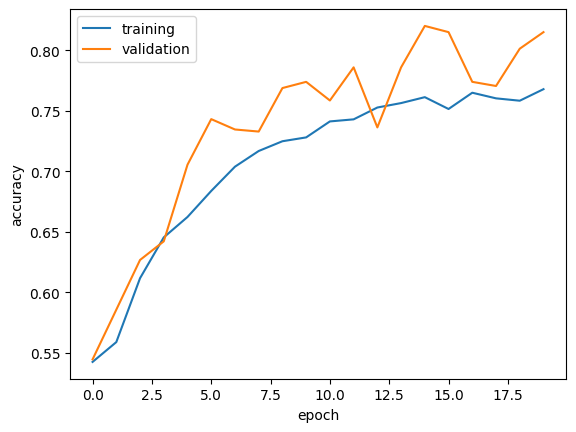

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

In [ ]:
model.evaluate(test_vec)

1169/1169 [==============================] - 6s 5ms/step - loss: 0.4377 - accuracy: 0.8204


[0.4376719295978546, 0.8203592896461487]